#                             ****EVALUATION TEST: DEEPLENSE****

# **Common Test I. Multi-Class Classification**

**Task: Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.**

**Dataset Description: The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.**

**Evaluation Metrics: ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)**

 **LET'S IMPORT SOME OF THE LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import keras
import os
warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.11.0


**Defining The Parameters--->**

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100
path = '/kaggle/input/gsoc2023/dataset/'
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': 3,
          'shuffle': True}

> #  **Lets us see how data looks like**

[[[0.0130039  0.00910273 0.01820546 ... 0.00910273 0.01560468 0.01170351]
  [0.01690507 0.01690507 0.01950585 ... 0.0130039  0.01040312 0.01560468]
  [0.00910273 0.00910273 0.01690507 ... 0.0130039  0.01430429 0.00780234]
  ...
  [0.01820546 0.01560468 0.00650195 ... 0.00910273 0.01820546 0.01040312]
  [0.01950585 0.00910273 0.01170351 ... 0.00650195 0.00910273 0.00780234]
  [0.02080624 0.01430429 0.01040312 ... 0.00910273 0.01430429 0.01040312]]]

Image Shape----->  (1, 150, 150)



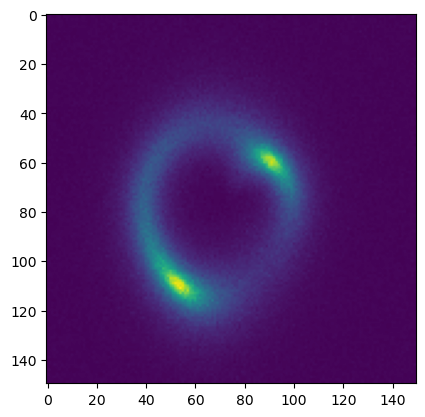

In [3]:
img = np.load('/kaggle/input/gsoc2023/dataset/train/no/1.npy')
print(img)#image is normalised using min-max() normalisation
print()
print("Image Shape-----> ",img.shape)
print()
img = np.array(img)
img = np.transpose(img)*255
plt.imshow(img.astype('uint8'))

> **modify() Function to reshape image from (150,150,1) to (150,150,3) and broadcast the image to size of (224,224,3)**

In [4]:
def modify(image):
    image = image.reshape((150,150,1))
    img = tf.reshape(tf.broadcast_to(image, (150, 150, 3)),  (150, 150, 3))
    img = tf.image.resize(np.array(img),[224,224])
    return img

> # CUSTOM DATA GENERATOR
**Since Dataset was Large enough to handle , We need efficient way to take care of it.**
Notations
Before getting started, let's go through a few organizational tips that are particularly useful when dealing with large datasets.
Let ID be the Python string that identifies a given sample of the dataset. A good way to keep track of samples and their labels is to adopt the following framework:
> > 1.) Create a dictionary called partition where you gather:
> > > in partition['train'] a list of training IDs

> > > in partition['validation'] a list of validation IDs

> > 2.) Create a dictionary called labels where for each ID of the dataset, the associated label is given by labels[ID]

> First, let's write the initialization function of the class. We make the latter inherit the properties of keras.utils.Sequence so that we can leverage nice functionalities such as multiprocessing.

> We put as arguments relevant information about the data, such as dimension sizes (e.g. a volume of length 32 will have dim=(32,32,32)), number of channels, number of classes, batch size, or decide whether we want to shuffle our data at generation. We also store important information such as labels and the list of IDs that we wish to generate at each pass.

> Here, the method on_epoch_end is triggered once at the very beginning as well as at the end of each epoch. If the shuffle parameter is set to True, we will get a new order of exploration at each pass (or just keep a linear exploration scheme otherwise).

> Shuffling the order in which examples are fed to the classifier is helpful so that batches between epochs do not look alike. Doing so will eventually make our model more robust.

> Another method that is core to the generation process is the one that achieves the most crucial job: producing batches of data. The private method in charge of this task is called __data_generation and takes as argument the list of IDs of the target batch.

> During data generation, this code reads the NumPy array of each example from its corresponding file ID.npy. Since our code is multicore-friendly, note that you can do more complex operations instead (e.g. computations from source files) without worrying that data generation becomes a bottleneck in the training process.

> Also, please note that we used Keras' keras.utils.to_categorical function to convert our numerical labels stored in y to a binary form (e.g. in a 6-class problem, the third label corresponds to [0 0 1 0 0 0]) suited for classification.

> Now comes the part where we build up all these components together. Each call requests a batch index between 0 and the total number of batches, where the latter is specified in the __len__ method.

> A common practice is to set this value to
                ⌊#samples/batch size⌋
so that the model sees the training samples at most once per epoch.
Now, when the batch corresponding to a given index is called, the generator executes the __getitem__ method to generate it.


In [5]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(150,150), n_channels=1,n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = np.load('/kaggle/input/gsoc2023/dataset/' + '/'.join(ID.split('_')) + '.npy')
            img = modify(np.array(img))
            X[i,] = img
#             X[i,] = tf.image.resize(img, [self.dim[0], self.dim[1]])
#             data_augmentation.layers[0].adapt(X)
            y[i] = self.labels[ID]

        return np.array(X), keras.utils.to_categorical(y, num_classes=self.n_classes)

**Generating the dictionary**

In [6]:
trains = []
labels = []
val = []
l=0
for k in os.listdir('/kaggle/input/gsoc2023/dataset/train/'):
#     print(k.dtype)
    train = []
    train = [f'train_{str(k)}_'+str(i) for i in range(1,10000)]
    trains+=(train)
    
for k in os.listdir('/kaggle/input/gsoc2023/dataset/val/'):
    validation =[f'val_{str(k)}_'+str(i) for i in range(1,2500)]
    val+=(validation)

In [7]:
partition = {'train': trains , 'validation' : val}
# partition
labels = {}
for i in range(1,10000):
    labels[f'train_no_{i}'] = 0
    labels[f'train_sphere_{i}'] = 1
    labels[f'train_vort_{i}'] = 2
    
for i in range(1,2500):
    labels[f'val_no_{i}'] = 0
    labels[f'val_sphere_{i}'] = 1
    labels[f'val_vort_{i}'] = 2

In [8]:
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# **The Transformer Architecture**

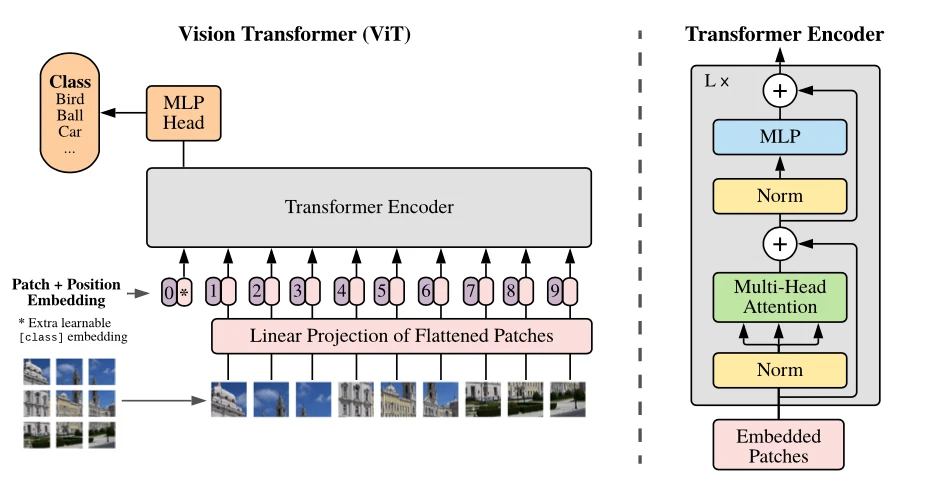

Vision transformer works on the basis on the following Steps : 

1. The input image is passed **Augmented** to make the **model robust** and also to **increase the size** of the **image dataset**. 

2. These Augmented images are then chopped into **Pathches/Chunks**. Each Patch is simply the sliced part of the Image.

 * Now these pathches can be created using **Conv Layers** with the right **Kernel Size and Strides**.

 * Other way is to simply **Chop the Image** without passing it through a network using **Tensorflow Image** module.

3. These **Pathches of Images** are then passed to a **Dense Layer** which learns the **Image Data** and also the **Positional Embedding** of each patch.

 * This **Positional Embedding** allow the network to understand the **Representation** of all the **Pathces as a Single Image**.

4. Then the **Ouput** is passed to a **Transformer Network** for **L time**. This transformer network consist of :

 * A normalization layer followed by a **Multi-Head Attention** layer, this **Multi-Head Attention** layer allow the model to undestand the **relatioship between these different Patches**.

 * The outputs are then added to the **Original Inputs** as a form of **Residual learning** so that the **Gradients** can flow easily during **BackPropogation**.

 * These **refined Outputs** are again passed through a **Normalization Layer** followed by a **MLP** which learns about the **Classes** and at **lower level** understand the **Attention Areas.** 

5. Finally, the outputs of the **Transformer Block(last)** is passed to a **MLP** which outputs the final **Class probabilities**.

---
$Note :$

This model only works when the dataset is **not just big it is Large**. The model was only able to **Outperform ResNet50** when the Number of Image in **Training Dataset** went above $300M$.

---

In [9]:
!pip install --quiet vit-keras

from vit_keras import vit

In [10]:
vit_model = vit.vit_b32(
        image_size = (224,224),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 3)

353253686/353253686 [==============================] - 1s 0us/step


# MODEL

In [11]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(3, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 3)          

In [12]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = [tf.keras.metrics.AUC()])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

callbacks = [reduce_lr]

history = model.fit(training_generator,validation_data = (validation_generator),epochs = EPOCHS,callbacks = callbacks, verbose = 1)



Epoch 1/100
468/468 [==============================] - 620s 1s/step - loss: 1.1479 - auc: 0.5249 - val_loss: 1.1333 - val_auc: 0.5517 - lr: 1.0000e-04
Epoch 2/100
468/468 [==============================] - 375s 801ms/step - loss: 1.0895 - auc: 0.5843 - val_loss: 1.1150 - val_auc: 0.6088 - lr: 1.0000e-04
Epoch 3/100
468/468 [==============================] - 368s 787ms/step - loss: 1.0709 - auc: 0.6248 - val_loss: 1.0854 - val_auc: 0.6581 - lr: 1.0000e-04
Epoch 4/100
468/468 [==============================] - 362s 773ms/step - loss: 1.0440 - auc: 0.6694 - val_loss: 1.0558 - val_auc: 0.6844 - lr: 1.0000e-04
Epoch 5/100
468/468 [==============================] - 361s 771ms/step - loss: 1.0175 - auc: 0.7092 - val_loss: 1.0124 - val_auc: 0.7135 - lr: 1.0000e-04
Epoch 6/100
468/468 [==============================] - 359s 768ms/step - loss: 0.9915 - auc: 0.7425 - val_loss: 1.2575 - val_auc: 0.6834 - lr: 1.0000e-04
Epoch 7/100
468/468 [==============================] - 360s 769ms/step - loss: 

In [13]:
model.save('model.h5')

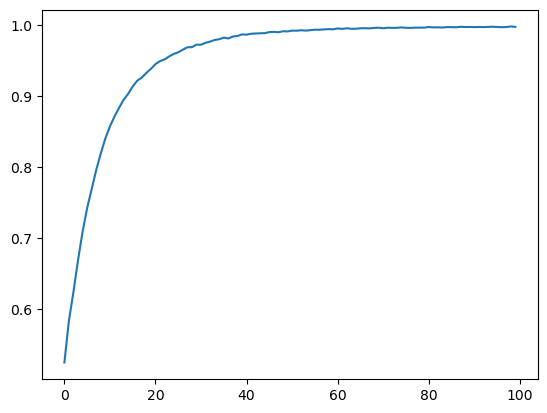

In [14]:
plt.plot(history.history['auc'])